## Problem Statement
Given the <font color='DarkGoldenRod'>two-moon dataset</font>, build a classifier capable of catogarizing **unseen** examples as either belonging to one of the moons.

## Building the model
Let's quickly explain how we will make our model:
* We have $x_0, x_1$ as parameters to the specific point, we want to calculate the weights for first node $a_0$: $w_{0, 0}, w_{0, 1}$ and bias $b$ for those paramaters.
* So our input for $a_0$ is $a_0 = w_{0,0} * x_0 + w_{0, 1} * x_1 + b_0$
* For second node $a_1$, we also have weights $w_{1, 0}, w_{1, 1}$ and bias $b_1$
* So our input for $a_1$ is $a_1 = w_{1,0} * x_0 + w_{1, 1} * x_1 + b_1$
* Let's put our $a_0, a_1, x_0, x_1, w_{0,0}, w_{0, 1}, w_{1, 0}, w{1, 1}$ to a matrix:
<br><br>
$$
a = \begin{bmatrix}
a_0 & a_1 \\
\end{bmatrix} \;\;
x = \begin{bmatrix}
x_0 & x_1 \\
\end{bmatrix}\\ \;\;
b = \begin{bmatrix}
b_0 & b_1 \\
\end{bmatrix} \\
w = \begin{bmatrix}
w_{0, 0} & w_{0, 1} \\
w_{1, 0} & w_{1, 1} \\
\end{bmatrix}\\
a = x . w^T + b
$$
* We will then apply $softmax$ for $a0, a1$:
$$softmax(a_0) = \frac{e^{a_0}}{e^{a_0} + e^{a_1}}, \;\; softmax(a_1) = \frac{e^{a_1}}{e^{a_0} + e^{a_1}}$$
* We will calculate the loss using cross entropy loss
$$L = -\sum_{C=0}^{C}y*log(\hat{y})\\
y → True\;label\\
\hat{y} \rightarrow Estimate\;output$$


In [60]:
from sklearn.datasets import make_moons
from math import floor
import numpy as np
N=1000
NOISE = 0.1
SEED = 5
x, y = make_moons(n_samples= N, shuffle= True, noise= NOISE, random_state= SEED)

TRAIN_PERCENT = 0.8

x_train, y_train = x[ : floor(TRAIN_PERCENT * N), :] , y[ : floor(TRAIN_PERCENT * N)]
x_valid,  y_valid = x[floor(TRAIN_PERCENT * N) : , :] , y[floor(TRAIN_PERCENT * N) : ]

train_zero_indices = np.argwhere(y_train == 0)
train_one_indices = np.argwhere(y_train == 1)
valid_zero_indices = np.argwhere(y_valid == 0)
valid_one_indices = np.argwhere(y_valid == 1)

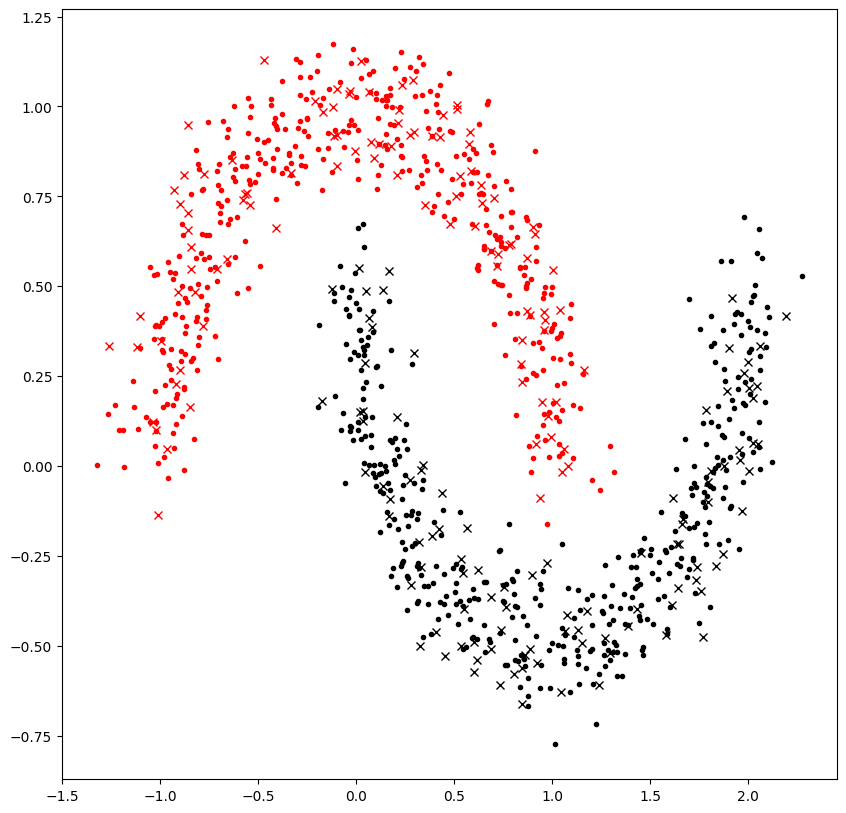

In [61]:
from matplotlib.pyplot import figure

fig = figure(figsize = (10,10))
ax_moon = fig.add_subplot(1,1,1)
#plotting train sample with red 
ax_moon.plot(x_train[train_zero_indices,0], x_train[train_zero_indices,1], "r.")
ax_moon.plot(x_valid[valid_zero_indices,0], x_valid[valid_zero_indices,1], "rx")
ax_moon.plot(x_train[train_one_indices,0], x_train[train_one_indices,1], "k.")
ax_moon.plot(x_valid[valid_one_indices,0], x_valid[valid_one_indices,1], "kx")

## using Pytorch

In [70]:

import torch

x_train_torch, y_train_torch = torch.tensor(x_train), torch.tensor(y_train)
x_valid_torch, y_valid_torch = torch.tensor(x_valid), torch.tensor(y_valid)

# we want to convert y from 0 _downward facing_ to (1,0) and from 1_upward facing_ to (0,1) 
y_train_torch = torch.nn.functional.one_hot(y_train_torch, num_classes = 2)
y_valid_torch = torch.nn.functional.one_hot(y_valid_torch, num_classes = 2)

#lets generate prameters of wights and bais

def gen_prameters():
    torch.manual_seed(SEED)
    w = torch.randn(size = (2,2))
    w = w.to(torch.float64)
    w.requires_grad = True
    w.retain_grad()

    torch.manual_seed(SEED)
    b = torch.randn(size = (1, 2))
    b = b.to(torch.float64)
    b.requires_grad = True
    b.retain_grad()

    return  w, b

w, b = gen_prameters()

w, b
# print(f"Weights shape : {w.shape}", f"bais shape {b.shape}")



(tensor([[-0.4868, -0.6038],
         [-0.5581,  0.6675]], dtype=torch.float64, requires_grad=True),
 tensor([[-0.4868, -0.6038]], dtype=torch.float64, requires_grad=True))

In [77]:
def predict(x, weights, bais):
    # x: tensore of shape (n_sample, n_features)
    a = x.to(torch.float64) @ weights.t() + bais
    return torch.softmax(a, dim = 1) # normalizes values along axis 1

In [82]:
#example:
y_hat = predict(torch.tensor([[1., 1.],
                             [2., 2.]]), w, b)

y_hat

tensor(0.7471, dtype=torch.float64, grad_fn=<SelectBackward0>)

#### loss function

In [73]:
def loss(x, y, weight, bais):
    y_hat = predict(x, weight, bais)
    return torch.mean(-(y * torch.log(y_hat)).sum(dim = 1))

loss_val = loss(x = torch.tensor([[1., 1.],
                             [2., 2.]]),
               y = torch.tensor([[0, 1], [1, 0]]), weight = w, bais = b)
loss_val

tensor(1.3359, dtype=torch.float64, grad_fn=<MeanBackward0>)

#### optemizing loop

In [80]:
EPOCHS = 1000
DELTA = 0.01

def model (x_train, y_train, x_valid, y_valid,
                weight, bais, epochs = EPOCHS, delta = DELTA):
    train_losses, valid_losses =[], []
    for _ in range(epochs):
        curr_train_loss = loss(x_train, y_train, weight, bais)
        curr_train_loss.backward()
        train_losses.append(curr_train_loss)

        curr_vaild_loss = loss(x_valid, y_valid, weight, bais)
        valid_losses.append(curr_vaild_loss)

        with torch.no_grad():
            weight -= delta * weight.grad.data
            bais -= delta * bais.grad.data

            weight.grad.zero_()
            bais.grad.zero_()

        # return weight, bais, train_losses, valid_losses
    





#### optemizing loop with SGD

In [113]:
from random import Random
from math import ceil
BATCH_SIZE = 4
EPOCHS = 1000
DELTA = 0.01
n = x_train.shape[0]
indices =torch.tensor([])
for i in range(n):
    for j in range(2):
        indices.append([i,j])
num_batches = ceil(n/BATCH_SIZE)

def model (x_train, y_train, x_valid, y_valid,
                weight, bais, epochs = EPOCHS, delta = DELTA):
    train_losses, valid_losses =[], []
    sampler = Random(SEED)
    for _ in range(epochs):
        sampler.shuffle(indices)
        for index in range(num_batches):
            batch_indices = indices[index * BATCH_SIZE : (index + 1) * BATCH_SIZE]
            
            batch_x_train = [x_train[k] for k in batch_indices]
            batch_y_train = [y_train[i] for i in batch_indices]
            batch_x_valid = [x_valid[i] for i in batch_indices]
            batch_y_valid = [y_valid[i] for i in batch_indices]



            # curr_train_loss = loss(x_train, y_train, weight, bais)
            # curr_train_loss.backward()
            # train_losses.append(curr_train_loss)

            # curr_vaild_loss = loss(x_valid, y_valid, weight, bais)
            # valid_losses.append(curr_vaild_loss)

            # with torch.no_grad():
            #     weight -= delta * weight.grad.data
            #     bais -= delta * bais.grad.data

            #     weight.grad.zero_()
            #     bais.grad.zero_()

            batch_x_train
model(x_train, y_train, x_valid, y_valid, w, b)

AttributeError: 'Tensor' object has no attribute 'append'

In [ ]:
import random
epochs = 1000
batch_size = 32
delta = 0.1
train_loss, valid_loss = [], []
for _ in range(epochs):

    indices = list(range(x_train.shape[0]))
    random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]

    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]
        current_train_loss = loss(x_batch, y_batch)
        current_train_loss.backward()
        with torch.no_grad():
            w -= delta * w.grad.data
            b -= delta * b.grad.data
            w.grad.zero_()
            b.grad.zero_()
            
    current_train_loss = loss(x_train, y_train)
    current_valid_loss = loss(x_valid, y_valid)
    train_loss.append(current_train_loss.data)
    valid_loss.append(current_valid_loss.data)